# Analise de tolerancia unidimensional

O Objetivo desta analise e avaliar a somatoria de tolerancias unidimensional entre 2 pecas estampadas, onde a folga é de 1,2mm,
portanto qualquer valor que ultrapasse 1,2mm é considerado interferência

Considerado peças com desvio padrão de 6 sigmas e critérios de qualidade de 8 sigmas

In [22]:
#importando bibliotecas
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns


## Definindo a quantidade de amostras a serem utilizadas

In [9]:
try:
    amostra = int(input('Insira a quantidade de amostras a serem simuladas:\nou deixe em branco para padrao'))
except ValueError:
    amostra = 100000
print(amostra)

Insira a quantidade de amostras a serem simuladas:
ou deixe em branco para padrao
100000


## Definiçaõ de funções

In [10]:
def tolerancia(tol,sigma=3,offset=0, sample=amostra):
    '''
    tol: ex=0.5, mean the tolerance equal +-0.5mm
    sigma: how many sigmas the process attend, default=3
    offset: nominal value, the center of gaussian curve, default=0
            You can use tol=1, offset=0.5, it means the tolerance is from 0 until +1mm
            if you use tol=0.5, offset=0, it means the tolerance is from -0.5 until +0.5mm
    sample: how many samples is simulated, default=100000
    '''
    c1 = tol/sigma
    s = pd.Series(tuple(norm.rvs(offset,c1, size=sample)))
    return s


def plothist(variavel):
    '''
    Histogram plot and '.PNG' file creation
    '''
    fig = plt.figure(figsize=(12,8))
    mean = variavel.mean()
    with plt.rc_context(dict(sns.axes_style("darkgrid"),
        
        **sns.plotting_context("notebook", font_scale=1.5))):
        points = sns.distplot(variavel , bins=60, color='#303090')
        sigma8p = variavel.quantile(0.99994)
        sigma8n = variavel.quantile(0.00006)
        probout = norm.sf(1.2, variavel.mean(), variavel.std())*100
        points.text(x=1.2+0.2, y=0.22, s=str(round(probout,2))+'%', color='r', weight='bold')
        points.text(x=sigma8n-1, y=0.02, s=str(round(sigma8n,2))+'mm', color='b', fontsize=16)
        points.text(x=sigma8p+0.1, y=0.02, s=str(round(sigma8p,2))+'mm', color='b', fontsize=16)
        points.text(x=1.2+0.075, y=0.34, s='Interferência (1.2mm)', color='r', fontsize=10, rotation=90)
        points.text(x=sigma8n+0.075, y=0.38, s='8 sigma - 99,994%', color='b', fontsize=8, rotation=90)
        points.text(x=sigma8p+0.075, y=0.38, s='8 sigma - 99,994%', color='b', fontsize=8, rotation=90)
        plt.title("Avaliacao de interferência", loc='left')
        plt.ylabel("Densidade de Probabilidade")
        plt.xlabel("Variação em mm")
        points = points.get_lines()[0].get_data()
        x = points[0]
        y = points[1]
        plt.fill_between(x,y, where = x<1.2, color='g')
        plt.fill_between(x,y, where = x>=1.2, color='r')

        plt.axvline(x=sigma8p, color='blue', linestyle='--')
        plt.axvline(x=sigma8n, color='blue', linestyle='--')
        plt.axvline(x=1.2, color='red', linestyle='--')
                
        plt.axvline(x=mean, color='black', linestyle='-')
        print('8Sigma: +{}mm / {}mm\nMédia {}mm'.format(sigma8p,sigma8n,mean))
        
    return plt.savefig(variavel.name+'.png', dpi=400, transparent=False)
    



In [11]:
#inserindo as tolerancias Peça 1
peca1_lc = tolerancia(0.5) #tolerancia da linha de corte da peca 1 | +-0,5mm
tol_furo1 = tolerancia(0.1, offset=0.1) #tolerancia do furo da peca 1 | 0/+0,2mm
tol_furo2 = tolerancia(0.1, offset=0.1) #tolerancia do furo da peca 2 | 0/+0,2mm
pinorps = tolerancia(0.1, offset=-0.1) #tolerancia do pino RPS no dispositivo | -0,2/0mm

'''para criar uma distribuicao uniforme, vamos gerar metade das amostras 
com valores negativos e a outra metade com valores positivos'''
amostra_m = int(amostra/2)
aj_neg= (np.random.random((amostra_m))*1) # referente a 1mm folga entre raios valores negativos
aj_pos= (np.random.random((amostra_m))*-1)# referente a 1mm folga entre raios valores positivos
folga_diametro = np.append(aj_neg, aj_pos, axis=0) #concatenacao dos valores negativos e positivos


#inserindo as tolerancias da peca2
peca2_lc = tolerancia(0.5) #linha de corte da peca 2 | +-0,5mm
peca2_conj = tolerancia(1.75) # variacao conhecida na conjunto onde a peca 2 é montada | +-1,75mm

In [12]:
#Total peca 1
tol_peca1 = (peca1_lc+tol_furo1+tol_furo2+pinorps+folga_diametro)
print('Máxima variação considerando 8 sigmas (99,994%): {} \ +{}'\
      .format(round(tol_peca1.quantile(.00006),3),round(tol_peca1.quantile(.99994),3)))
print(tol_peca1.describe())

Máxima variação considerando 8 sigmas (99,994%): -1.396 \ +1.612
count    100000.000000
mean          0.099378
std           0.603735
min          -1.494191
25%          -0.400932
50%           0.096926
75%           0.600150
max           1.700756
dtype: float64


In [13]:
#Total Peca 2
tol_peca2 = (peca2_lc+peca2_conj)
print('Máxima variação considerando 8 sigmas (99,994%): {} \ +{}'\
      .format(round(tol_peca2.quantile(.00006),3),round(tol_peca2.quantile(.99994),3)))
print(tol_peca2.describe())

Máxima variação considerando 8 sigmas (99,994%): -2.279 \ +2.321
count    100000.000000
mean         -0.000769
std           0.608385
min          -2.461642
25%          -0.414172
50%          -0.001172
75%           0.410886
max           2.632656
dtype: float64


In [14]:
#Total
tol_total = (tol_peca1+tol_peca2)
print('Máxima variação considerando 8 sigmas (99,994%): {} \ +{}'\
      .format(round(tol_total.quantile(.00006),3),round(tol_total.quantile(.9994),3)))
print(tol_total.describe())

Máxima variação considerando 8 sigmas (99,994%): -2.877 \ +2.687
count    100000.000000
mean          0.098609
std           0.857758
min          -3.101394
25%          -0.506527
50%           0.098239
75%           0.699207
max           3.596526
dtype: float64


In [15]:
#Nomenado as Series

tol_total.name = 'Total'


In [16]:
#negrito
start = "\033[1m"
end = "\033[0;0m"

In [24]:
#imprimir resumo para cada peça

print(start+'\nSomatória Total'+end)
print(tol_total.describe())
print(start+'\nSomatória peça 1'+end)
print(tol_peca1.describe())
print(start+'\nSomatória peça 2'+end)
print(tol_peca2.describe())



Somatória Total
count    100000.000000
mean          0.098609
std           0.857758
min          -3.101394
25%          -0.506527
50%           0.098239
75%           0.699207
max           3.596526
Name: Total, dtype: float64

Somatória peça 1
count    100000.000000
mean          0.099378
std           0.603735
min          -1.494191
25%          -0.400932
50%           0.096926
75%           0.600150
max           1.700756
dtype: float64

Somatória peça 2
count    100000.000000
mean         -0.000769
std           0.608385
min          -2.461642
25%          -0.414172
50%          -0.001172
75%           0.410886
max           2.632656
dtype: float64


In [25]:
#Imprime qual a variação máxima considerando 6 sigmas
tsigma8p = tol_total.quantile(0.99994)
tsigma8n = tol_total.quantile(0.00006)
print('Máxima variação considerando 8 sigmas (99,994%): {} \ +{}'.format(round(tsigma8n,3),round(tsigma8p,3)))

Máxima variação considerando 8 sigmas (99,994%): -2.877 \ +3.213


In [26]:
#Imprime qual a variação máxima considerando 6 sigmas
tsigma6p = tol_total.quantile(0.997)
tsigma6n = tol_total.quantile(0.003)
print('Máxima variação considerando 6 sigmas (99,97%): {} \ +{}'.format(round(tsigma6n,3),round(tsigma6p,3)))

Máxima variação considerando 6 sigmas (99,97%): -2.142 \ +2.359


C:\Users\caior\AppData\Roaming\Python\Python37\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9991347193717957, 2.215693097367929e-20)


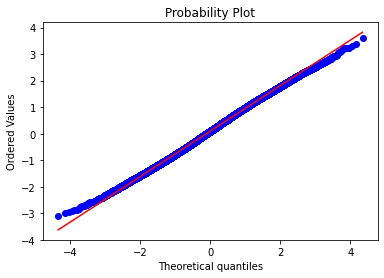

In [27]:
#Verificar se a distribuição é normal
stats.probplot(tol_total, plot=plt)
print(stats.shapiro(tol_total))

8Sigma: +3.2126340504351mm / -2.8769239493992416mm
Média 0.09860870996595557mm


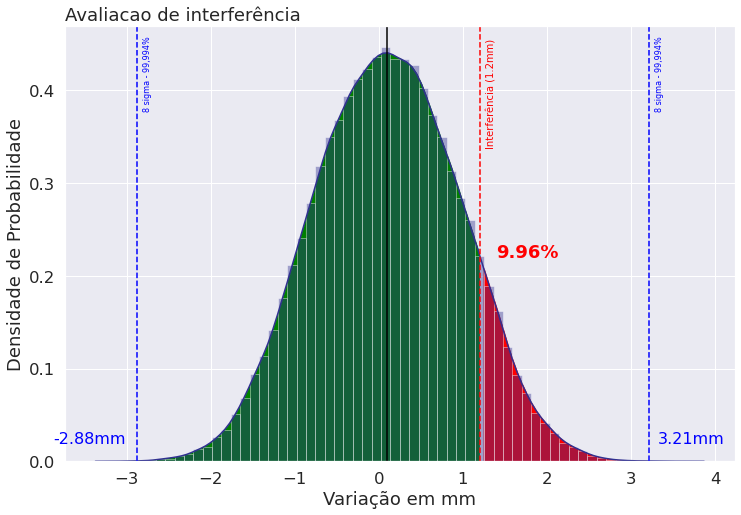

In [28]:
plothist(tol_total)
